In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3
import numpy as np
import pandas as pd
from src.tables_old import MapTable, df_to_tmp_table, df_to_table, get_machines, get_offers, get_tables, get_tbl_info, table_to_df, get_tbl_timespan
from src.preprocess import preprocess
from src.utils import  time_utc_now, np_min_chunk, df_na_vals, reduce_mem_usage
import seaborn as sns
import matplotlib.pyplot as plt
import logging

import warnings

# Filter out all warnings related to pandas
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
from src.manager import DbManager

dbm = DbManager('../data/vast.db')
# dbm = DbManager('../vast.db')

dbm.connect()
ts = dbm.table_to_df('ts_idx').timestamp
dbm.close()

sec = pd.to_datetime(ts * 1e9).diff().dt.seconds
sec.describe()

# sec

count    17007.000000
mean        55.449050
std          7.689645
min          1.000000
25%         53.000000
50%         54.000000
75%         56.000000
max        273.000000
Name: timestamp, dtype: float64

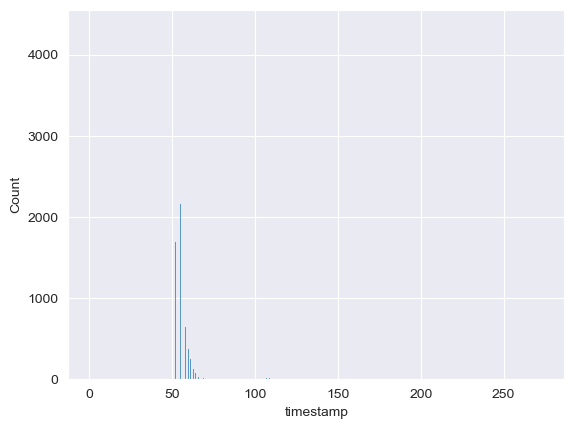

In [5]:
import seaborn as sns
sns.histplot(sec);

In [8]:
dbm.close()

In [7]:
import sqlite3
import os
import pandas as pd
from src.manager import DbManager

db_path = '../data/vast.db'
# db_path = '../vast.db'

dbm = DbManager(db_path)
dbm.connect()
timespan = dbm.get_tbl_timespan('ts_idx')
total_days = timespan.total_seconds() / (3600 * 24)

print('Timespan:', timespan)

dbm.execute('VACUUM')
size = os.path.getsize(db_path) / (1024 * 1024) # Size in Mb

try:
    print(f'Size: {size: .2f} mb')
    print(f'Size per day: {size / total_days: .2f} mb')
    print(f'Size per year: {size / total_days * 365: .0f} mb')
except:
    pass

dbm.close()

Timespan: 10 days 21:57:02
Size:  55.99 mb
Size per day:  5.13 mb
Size per year:  1872 mb


In [9]:
dbm.connect()
dbm.get_db_stats()

,name,pages,size,percentage
0,total,14334,55.99,100.00
1,reliability_ts,6068,23.70,42.33
2,avg_snp,5726,22.37,39.95
3,eod_ts,586,2.29,4.09
4,avg_ts,488,1.91,3.40
5,cost_ts,454,1.77,3.17
6,rent_ts,439,1.71,3.06
7,disk_ts,280,1.09,1.95
8,hardware_ts,70,0.27,0.49
9,hardware_snp,49,0.19,0.34


In [13]:
ts = [x[0] for x in dbm.execute('SELECT DISTINCT timestamp FROM avg_ts').fetchall()]
print(pd.to_datetime(pd.Series(ts), unit='s'))

0    2023-10-20 00:00:00
1    2023-10-21 00:00:00
2    2023-10-22 00:00:00
3    2023-10-23 00:00:00
4    2023-10-23 04:50:00
5    2023-10-24 00:00:00
6    2023-10-25 00:00:00
7    2023-10-26 00:00:00
8    2023-10-27 00:00:00
9    2023-10-28 00:00:00
10   2023-10-29 00:00:00
11   2023-10-30 00:00:00
dtype: datetime64[ns]


In [14]:
dbm.execute('SELECT DISTINCT timestamp FROM avg_ts').fetchall()

[(1697760000,),
 (1697846400,),
 (1697932800,),
 (1698019200,),
 (1698036600,),
 (1698105600,),
 (1698192000,),
 (1698278400,),
 (1698364800,),
 (1698451200,),
 (1698537600,),
 (1698624000,)]

In [15]:
import math
period = pd.to_timedelta('1 day').total_seconds()
end = int(math.ceil(dbm.get_last_ts('avg_snp') / period) * period)
print(pd.to_datetime(end, unit='s'), end)

2023-10-31 00:00:00 1698710400


In [26]:
ts = 1697932800
int(math.ceil(ts / period) * period)

1697932800

In [16]:
pd.to_datetime(dbm.table_to_df('avg_ts').timestamp.unique(), unit='s')

DatetimeIndex(['2023-10-20 00:00:00', '2023-10-21 00:00:00',
               '2023-10-22 00:00:00', '2023-10-23 00:00:00',
               '2023-10-23 04:50:00', '2023-10-24 00:00:00',
               '2023-10-25 00:00:00', '2023-10-26 00:00:00',
               '2023-10-27 00:00:00', '2023-10-28 00:00:00',
               '2023-10-29 00:00:00', '2023-10-30 00:00:00'],
              dtype='datetime64[ns]', freq=None)

In [14]:
dbm.close()

In [8]:
from src.manager import DbManager
dbm = DbManager(db_path)
dbm.connect()
dbm.get_db_stats()

,name,pages,size,percentage
0,total,3105,12.13,100.00
1,reliability_ts,2041,7.97,65.73
2,eod_ts,302,1.18,9.73
3,avg_ts,161,0.63,5.18
4,cost_ts,152,0.59,4.89
5,rent_ts,141,0.55,4.54
6,disk_ts,86,0.34,2.77
7,hardware_ts,51,0.20,1.64
8,hardware_snp,44,0.17,1.42
9,eod_snp,28,0.11,0.90


In [7]:
dbm.get_tbl_timespan('ts_idx')

Timedelta('3 days 21:34:05')

In [113]:
df = dbm.table_to_df('timestamp_tbl')

In [114]:
df.timestamp.diff().describe()

count    38694.000000
mean        74.742260
std         36.997593
min         49.000000
25%         52.000000
50%         54.000000
75%        103.000000
max       3471.000000
Name: timestamp, dtype: float64

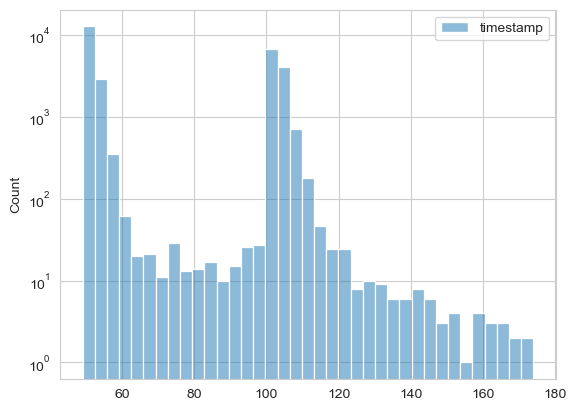

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df.diff().query('timestamp < 200'))
plt.yscale('log');

In [19]:
dbm.disconnect()

In [40]:
df.groupby('machine_id')['disk_bw'].resample('1D').mean().round().astype(np.uint16).reset_index().to_sql('disk_bw_avg', conn, if_exists='replace', index=False)

4553

In [41]:
df.groupby('machine_id')['disk_bw'].resample('1D').std().fillna(0).astype(np.uint16).reset_index().to_sql('disk_bw_std', conn, if_exists='replace', index=False)

4553

In [115]:
conn.close()

In [23]:
import sqlite3
import os
import numpy as np

DB_PATH = '../data'

# Create directories for databases if they don't exist
if not os.path.exists(DB_PATH):
    os.makedirs(DB_PATH)

# Function to create and populate a database with the specified data type and range
def create_and_populate_db(db_name, data_type, value_range, size=100000):
    db_path = os.path.join(DB_PATH, db_name)

    conn = sqlite3.connect(db_path)

    conn.execute(f"CREATE TABLE data (value {data_type})")


    # Generate and insert values within the specified range
    values = None
    if 'INTEGER' in data_type:
        values = np.random.randint(*value_range, size=size, dtype=np.uint32)
    elif 'REAL' in data_type:
        values = np.random.uniform(*value_range, size=size).astype(np.float32)
    else:
        raise ValueError('Unknown type')        
        
    rows = [(value,) for value in values]
    
    
    try:
        # print(rows[:3])
        # conn.executemany("INSERT INTO data (value) VALUES (?)", rows)

        for value in values:
            conn.execute(f"INSERT INTO data (value) VALUES ({value})")

        conn.commit()  
        conn.execute("VACUUM")    
    
    except Exception as e:
        print(e)
    
    conn.close()

# delete exiting db's
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    os.remove(db_path)


# Create and populate the databases
create_and_populate_db('integer_db.sqlite', 'INTEGER', (0, 300))  
# create_and_populate_db('integer_non_null_db.sqlite', 'INTEGER NOT NULL', (0, 1000))
create_and_populate_db('real_db.sqlite', 'REAL', (0, 1))            
# create_and_populate_db('real_non_null_db.sqlite', 'REAL NOT NULL', (0, 1000))            
# Print database sizes
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    db_size = os.path.getsize(db_path) / (1024)  # Size in KB
    print(f"Database '{db_name}' size: {db_size:.2f} KB")

Database 'integer_db.sqlite' size: 932.00 KB
Database 'real_db.sqlite' size: 1564.00 KB


In [48]:
import os
import psutil

In [49]:
# Getting loadover15 minutes
load1, load5, load15 = psutil.getloadavg()

cpu_usage = (load15/os.cpu_count()) * 100

print("The CPU usage is : ", load1)

The CPU usage is :  0.0
